<a href="https://colab.research.google.com/github/mimomaina/Machinelearning001/blob/main/Blueberry_yield_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# 2. Download data into colab

In [8]:
# Install Kaggle
!pip install -q kaggle

# Upload kaggle.json (your API token from https://kaggle.com/<your-username>/account)
from google.colab import files
files.upload()  # Upload kaggle.json here

# Make directory and copy token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Pull the competition data
!kaggle competitions download -c blueberry-yield-zindua-machine-week-2-challenge

# Unzip files
!unzip blueberry-yield-zindua-machine-week-2-challenge.zip

Saving kaggle.json to kaggle (1).json
  0% 0.00/634k [00:00<?, ?B/s]
100% 634k/634k [00:00<00:00, 598MB/s]
Archive:  blueberry-yield-zindua-machine-week-2-challenge.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [9]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [10]:
print("Training data shape:", train.shape)
print("Test data shape:", test.shape)
print("\nTrain head:")
print(train.head())

Training data shape: (15289, 18)
Test data shape: (10194, 17)

Train head:
   id  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
0   0       25.0      0.50     0.25     0.75   0.50              69.7   
1   1       25.0      0.50     0.25     0.50   0.50              69.7   
2   2       12.5      0.25     0.25     0.63   0.63              86.0   
3   3       12.5      0.25     0.25     0.63   0.50              77.4   
4   4       25.0      0.50     0.25     0.63   0.63              77.4   

   MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  MinOfLowerTRange  \
0              42.1                  58.2              50.2              24.3   
1              42.1                  58.2              50.2              24.3   
2              52.0                  71.9              62.0              30.0   
3              46.8                  64.7              55.8              27.0   
4              46.8                  64.7              55.8              27.0   


# 3. Data Preprocessing

In [16]:
print(train.columns.tolist())

['id', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds', 'yield']


In [17]:
X = train.drop(columns=['yield', 'id'])  # Features
y = train['yield']                         # Target
test_ids = test['id']                    # Save test IDs for submission
X_test = test.drop(columns=['id'])       # Test features


# 4. Feature Engineering

In [18]:
X['fruitset_x_fruitmass'] = X['fruitset'] * X['fruitmass']
X['seeds_per_fruit'] = X['seeds'] / (X['fruitmass'] + 1e-6)
X['total_bees'] = X['honeybee'] + X['bumbles'] + X['andrena'] + X['osmia']

X_test['fruitset_x_fruitmass'] = X_test['fruitset'] * X_test['fruitmass']
X_test['seeds_per_fruit'] = X_test['seeds'] / (X_test['fruitmass'] + 1e-6)
X_test['total_bees'] = X_test['honeybee'] + X_test['bumbles'] + X_test['andrena'] + X_test['osmia']

In [19]:
#Split training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

# Store results
results = []

for name, model in models.items():
    # Create pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Fit
    pipeline.fit(X_train, y_train)

    # Predict on validation
    y_pred = pipeline.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    results.append((name, mae))
    print(f"{name} - Validation MAE: {mae:.4f}")



Linear Regression - Validation MAE: 369.2914
Ridge - Validation MAE: 369.7115
Lasso - Validation MAE: 370.5572
ElasticNet - Validation MAE: 377.6202


In [21]:
# Find best model
results_df = pd.DataFrame(results, columns=['Model', 'MAE'])
best_model_name = results_df.loc[results_df['MAE'].idxmin(), 'Model']
print(f"\n Best Model: {best_model_name}")

# 5. Retrain Best Model on Full Training Data
print("\nRetraining best model on full training data.")

best_model = models[best_model_name]
full_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_model)
])

# Train on full training set
full_pipeline.fit(X, y)

# Predict on test set
test_preds = full_pipeline.predict(X_test)

# 6. Create Submission File

submission = pd.DataFrame({
    'id': test_ids,
    'yield': test_preds
})

submission.to_csv('submission.csv', index=False)

print("\n Submission file created:")
print(submission.head())




 Best Model: Linear Regression

Retraining best model on full training data.

 Submission file created:
      id        yield
0  15289  4327.225082
1  15290  6160.650198
2  15291  7214.249573
3  15292  5005.088708
4  15293  3648.051840


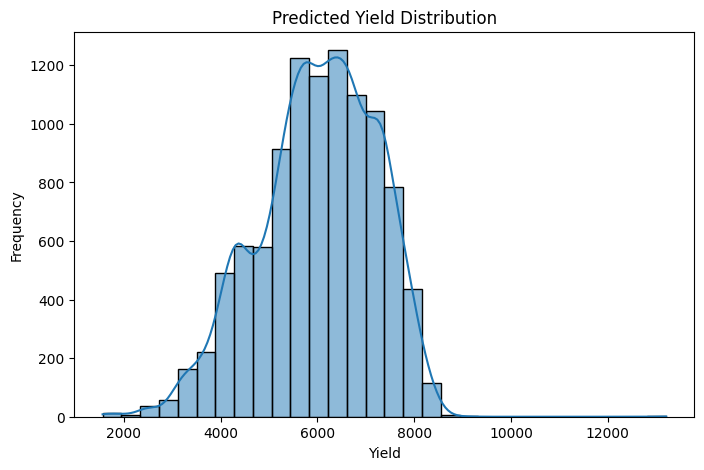

In [22]:
# Plot predicted yield distribution
plt.figure(figsize=(8, 5))
sns.histplot(submission['yield'], kde=True, bins=30)
plt.title('Predicted Yield Distribution')
plt.xlabel('Yield')
plt.ylabel('Frequency')
plt.show()